# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook demonstrates what a user sees when the user runs the User Guide for Real-World Data Notebook

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model_run, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/test_backtest_plot_'+model_run+model+'.png')
    tmp_weights.to_csv(root+'/temp_persisted_data/test_backtest_weights_'+model_run+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF

data_env_two_asset = root+ "/data_env/"

pd.read_parquet(data_env_two_asset+'MTUM.parquet').head()



,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,72.59413,72.90881,72.21272,72.54646,297832
2017-01-04 05:00:00+00:00,72.69902,73.09952,72.69902,72.97556,225891
2017-01-05 05:00:00+00:00,72.98509,73.25208,72.84206,73.21394,412561
2017-01-06 05:00:00+00:00,73.20441,73.77654,73.04230,73.63351,260918
2017-01-09 05:00:00+00:00,73.66212,73.76701,73.50001,73.60490,165800


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index <= '2020-04-01']
portfolio_df_train = portfolio_df_train[portfolio_df_train.index >= '2018-01-24']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2018-01-24 05:00:00+00:00,61.12980,69.58079,107.7541,83.47868,83.06821,51.58798,82.14153
2018-01-25 05:00:00+00:00,61.04514,69.44351,107.9952,83.49772,83.17646,51.84317,81.73357
2018-01-26 05:00:00+00:00,61.58129,69.98347,109.5190,84.36412,83.73291,52.27796,82.88330
2018-01-29 05:00:00+00:00,60.93227,69.34284,108.6896,83.62149,83.54300,51.88098,82.45679
2018-01-30 05:00:00+00:00,60.17979,68.96762,107.0211,82.72653,82.57443,51.57853,81.20506


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2020-04-16 04:00:00+00:00,48.20911,62.50506,116.0638,86.18110,75.67554,57.85078,65.36022
2020-04-17 04:00:00+00:00,48.88692,63.45106,117.9653,88.67091,78.40196,59.53394,67.65253
2020-04-20 04:00:00+00:00,48.48617,62.79575,116.7009,87.05402,77.06354,58.23692,66.08150
2020-04-21 04:00:00+00:00,47.54613,61.94337,112.3304,84.47494,74.79317,56.78149,63.82873
2020-04-22 04:00:00+00:00,48.56533,62.75141,115.3270,86.41917,76.31997,57.81118,65.00452


In [9]:
test_input_returns = portfolio_df_test.to_returns().dropna()
test_input_returns = test_input_returns.loc[(test_input_returns != 0).any(1)]


# Set Up Environment

In [10]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":10,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

detrend=False

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_world", data_dir="data_env", detrend=detrend)

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 10, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


#### Split Features and Forward Returns into Training and Test sets

In [11]:
features = pd.read_parquet("temp_persisted_data/only_features_real_world")
features

,EEMV.parquet_log_returns,EFAV.parquet_log_returns,MTUM.parquet_log_returns,QUAL.parquet_log_returns,SIZE.parquet_log_returns,USMV.parquet_log_returns,VLUE.parquet_log_returns,EEMV.parquet_log_returns_lag_0,EFAV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_0,...,USMV.parquet_log_returns_lag_12,VLUE.parquet_log_returns_lag_12,EEMV.parquet_log_returns_lag_13,EFAV.parquet_log_returns_lag_13,MTUM.parquet_log_returns_lag_13,QUAL.parquet_log_returns_lag_13,SIZE.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,VLUE.parquet_log_returns_lag_13,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-24 05:00:00+00:00,0.005864,0.005011,-0.002235,-0.002620,-0.000114,0.000550,-0.002931,0.002014,0.004770,0.001251,...,0.003964,0.005525,0.005179,0.002861,0.009956,0.007060,0.004521,0.002083,0.001180,1
2018-01-25 05:00:00+00:00,-0.001386,-0.001975,0.002235,0.000228,0.001302,0.004935,-0.004979,0.005864,0.005011,-0.002235,...,0.005074,0.004562,0.003545,0.005427,0.008348,0.004521,0.001779,0.003964,0.005525,1
2018-01-26 05:00:00+00:00,0.008745,0.007745,0.014011,0.010323,0.006668,0.008352,0.013969,-0.001386,-0.001975,0.002235,...,0.001686,0.001982,0.006573,0.002297,0.007997,0.006507,0.008025,0.005074,0.004562,1
2018-01-29 05:00:00+00:00,-0.010595,-0.009196,-0.007602,-0.008842,-0.002271,-0.007623,-0.005159,0.008745,0.007745,0.014011,...,0.000561,-0.000116,0.001277,-0.000270,0.002807,0.003061,0.001644,0.001686,0.001982,1
2018-01-30 05:00:00+00:00,-0.012426,-0.005426,-0.015470,-0.010760,-0.011661,-0.005847,-0.015297,-0.010595,-0.009196,-0.007602,...,-0.004874,0.000116,-0.001437,0.000135,0.003731,0.003052,0.002344,0.000561,-0.000116,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10 05:00:00+00:00,0.000856,0.006381,-0.012501,-0.001714,0.002722,0.007082,0.013513,0.007563,0.009576,-0.029419,...,0.003399,0.014091,0.004420,-0.002052,-0.005482,0.001599,-0.003368,0.001394,-0.004141,1
2020-11-11 05:00:00+00:00,0.006310,0.008585,0.020153,0.003064,0.003005,0.004793,-0.000986,0.000856,0.006381,-0.012501,...,0.003080,-0.006709,-0.001589,-0.002350,-0.000939,0.005530,0.009360,0.003399,0.014091,1
2020-11-12 05:00:00+00:00,-0.004430,-0.009575,-0.002721,-0.011950,-0.013448,-0.010364,-0.017783,0.006310,0.008585,0.020153,...,-0.014872,-0.024372,0.003175,0.006449,0.002614,0.005127,0.005453,0.003080,-0.006709,1


In [12]:
features = pd.read_parquet("temp_persisted_data/only_features_real_world")

features_train = features[features.index <= '2020-04-01']
features_train.sub(features_train.mean()) 

features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']
features_test.sub(features_test.mean())

features_train.head()

,EEMV.parquet_log_returns,EFAV.parquet_log_returns,MTUM.parquet_log_returns,QUAL.parquet_log_returns,SIZE.parquet_log_returns,USMV.parquet_log_returns,VLUE.parquet_log_returns,EEMV.parquet_log_returns_lag_0,EFAV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_0,...,USMV.parquet_log_returns_lag_12,VLUE.parquet_log_returns_lag_12,EEMV.parquet_log_returns_lag_13,EFAV.parquet_log_returns_lag_13,MTUM.parquet_log_returns_lag_13,QUAL.parquet_log_returns_lag_13,SIZE.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,VLUE.parquet_log_returns_lag_13,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-24 05:00:00+00:00,0.005864,0.005011,-0.002235,-0.002620,-0.000114,0.000550,-0.002931,0.002014,0.004770,0.001251,...,0.003964,0.005525,0.005179,0.002861,0.009956,0.007060,0.004521,0.002083,0.001180,1
2018-01-25 05:00:00+00:00,-0.001386,-0.001975,0.002235,0.000228,0.001302,0.004935,-0.004979,0.005864,0.005011,-0.002235,...,0.005074,0.004562,0.003545,0.005427,0.008348,0.004521,0.001779,0.003964,0.005525,1
2018-01-26 05:00:00+00:00,0.008745,0.007745,0.014011,0.010323,0.006668,0.008352,0.013969,-0.001386,-0.001975,0.002235,...,0.001686,0.001982,0.006573,0.002297,0.007997,0.006507,0.008025,0.005074,0.004562,1
2018-01-29 05:00:00+00:00,-0.010595,-0.009196,-0.007602,-0.008842,-0.002271,-0.007623,-0.005159,0.008745,0.007745,0.014011,...,0.000561,-0.000116,0.001277,-0.000270,0.002807,0.003061,0.001644,0.001686,0.001982,1
2018-01-30 05:00:00+00:00,-0.012426,-0.005426,-0.015470,-0.010760,-0.011661,-0.005847,-0.015297,-0.010595,-0.009196,-0.007602,...,-0.004874,0.000116,-0.001437,0.000135,0.003731,0.003052,0.002344,0.000561,-0.000116,1


In [13]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_real_world")

forward_return_dates_train = forward_return_dates[forward_return_dates.index <= '2020-04-01']

forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_train.head()

,"forward_return_7_days,_0:00:00"
index,
2018-01-24 05:00:00+00:00,2018-01-31 05:00:00+00:00
2018-01-25 05:00:00+00:00,2018-02-01 05:00:00+00:00
2018-01-26 05:00:00+00:00,2018-02-02 05:00:00+00:00
2018-01-29 05:00:00+00:00,2018-02-05 05:00:00+00:00
2018-01-30 05:00:00+00:00,2018-02-06 05:00:00+00:00


In [14]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_real_world")

forward_returns_train = forward_returns[forward_returns.index <= '2020-04-01']
forward_returns_train.sub(forward_returns_train.mean()) 

forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']
forward_returns_test.sub(forward_returns_test.mean()) 

forward_returns_train.head()

,"EEMV.parquet_forward_return_7_days,_0:00:00","EFAV.parquet_forward_return_7_days,_0:00:00","MTUM.parquet_forward_return_7_days,_0:00:00","QUAL.parquet_forward_return_7_days,_0:00:00","SIZE.parquet_forward_return_7_days,_0:00:00","USMV.parquet_forward_return_7_days,_0:00:00","VLUE.parquet_forward_return_7_days,_0:00:00"
index,,,,,,,
2018-01-24 05:00:00+00:00,-0.008001,-0.009207,-0.001074,-0.011291,-0.008116,0.000733,-0.014900
2018-01-25 05:00:00+00:00,-0.014484,-0.004744,-0.004286,-0.010718,-0.007695,-0.006928,-0.011912
2018-01-26 05:00:00+00:00,-0.038949,-0.026939,-0.040772,-0.041079,-0.031073,-0.031640,-0.051012
2018-01-29 05:00:00+00:00,-0.051868,-0.051603,-0.074801,-0.069566,-0.062628,-0.059392,-0.082762
2018-01-30 05:00:00+00:00,-0.024539,-0.036093,-0.037578,-0.044884,-0.045308,-0.047829,-0.046700


# Run Policy-Gradient Method Algorithms on Real-World Data

In [15]:
max_iter = 4001
model_run = "7ETF_reward_variance_risk_10_"
sample_observations = 32
plot_interval = 500

### REINFORCE

 12%|█████████▊                                                                     | 500/4001 [02:50<21:29,  2.71it/s]

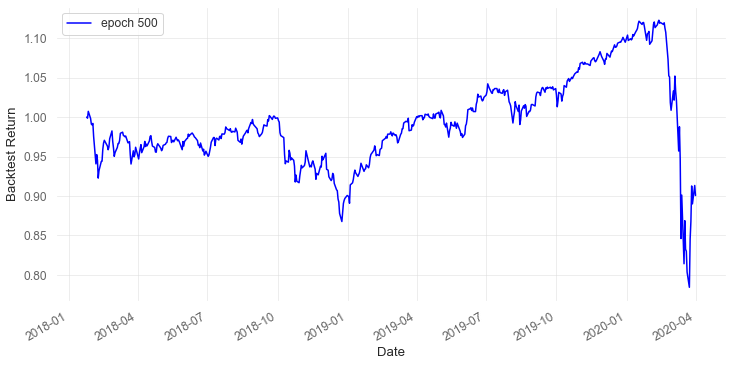

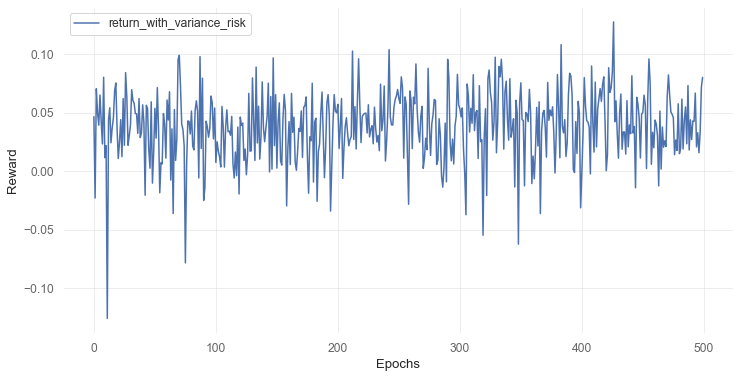

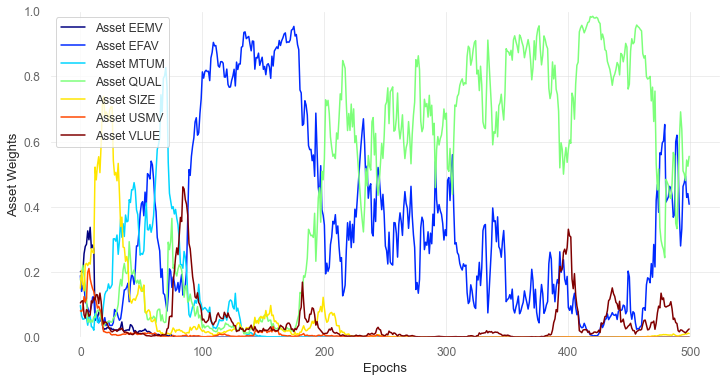

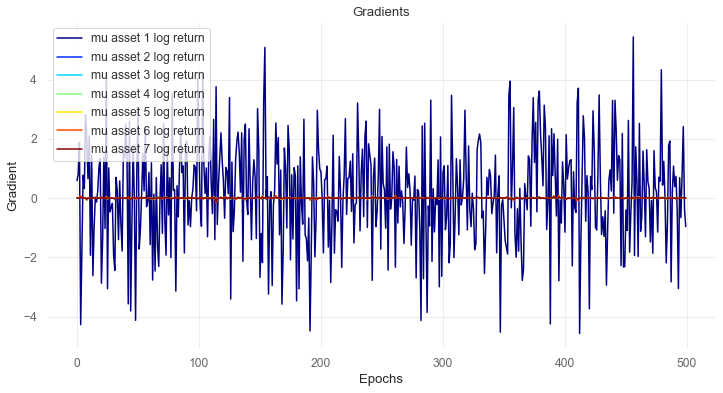

 25%|███████████████████▍                                                          | 1000/4001 [06:03<16:06,  3.11it/s]

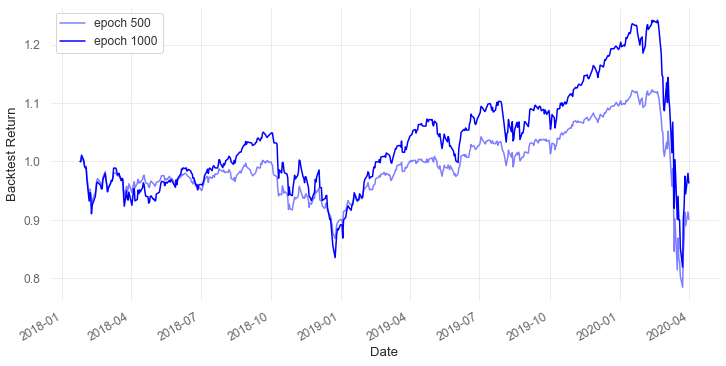

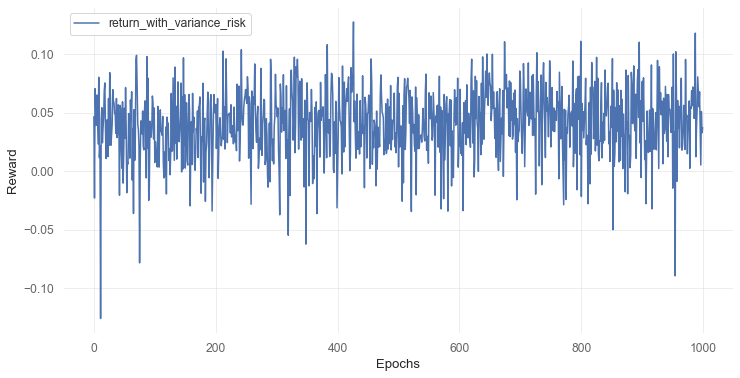

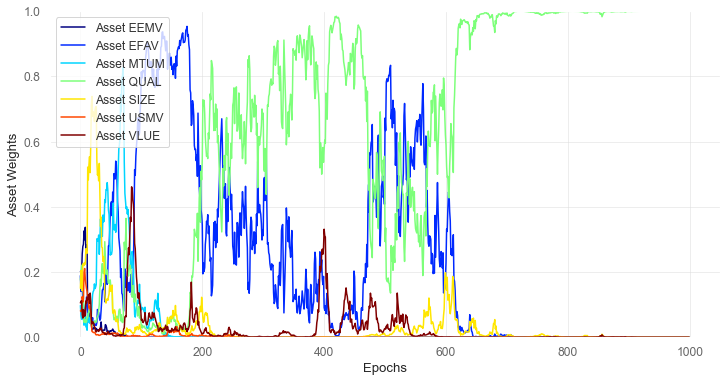

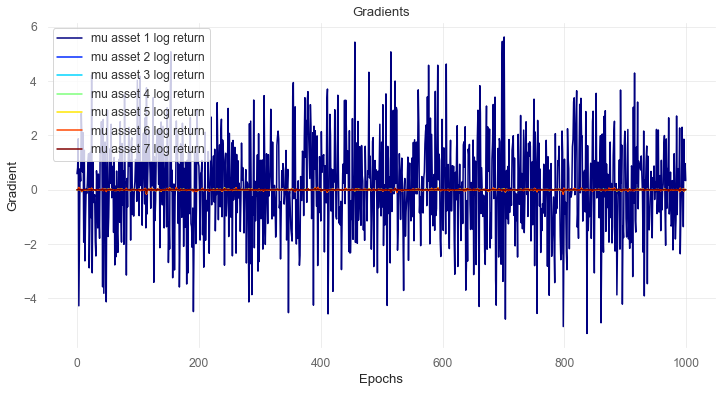

 37%|█████████████████████████████▏                                                | 1500/4001 [09:29<19:38,  2.12it/s]

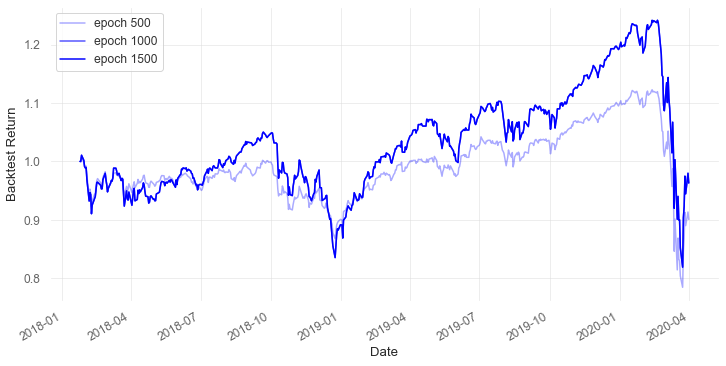

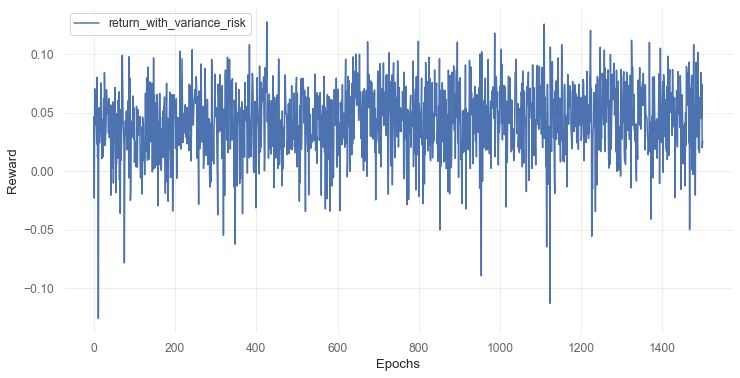

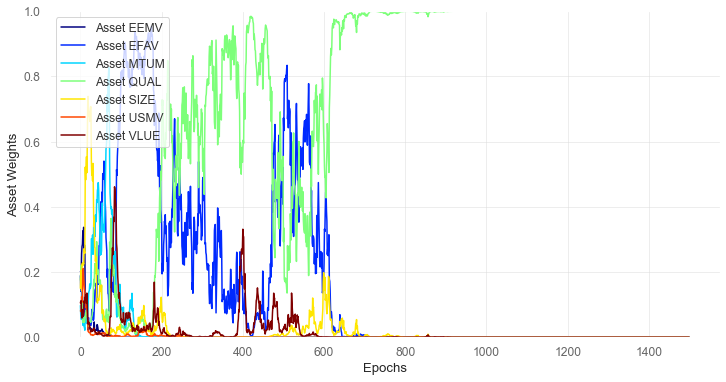

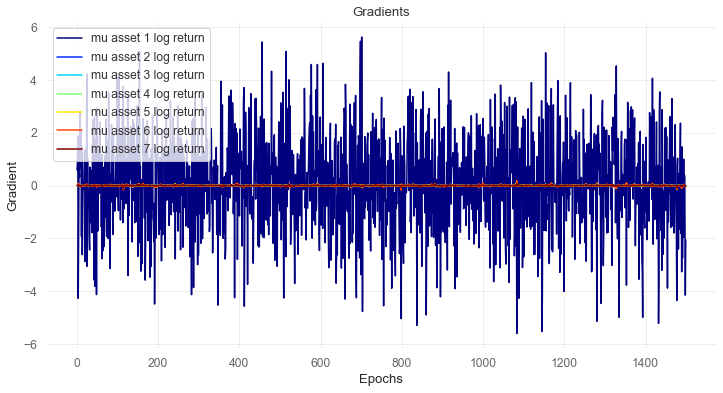

 50%|██████████████████████████████████████▉                                       | 2000/4001 [12:55<10:06,  3.30it/s]

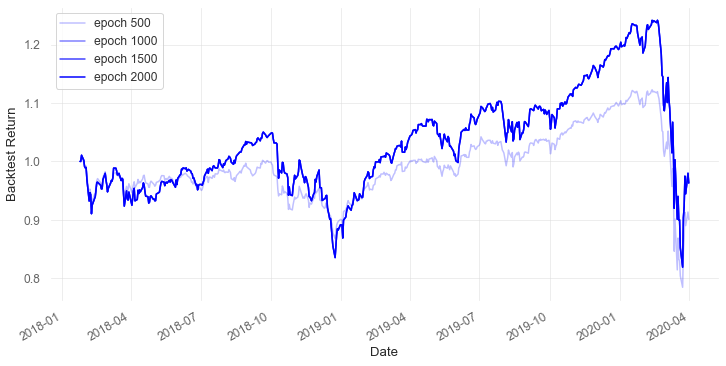

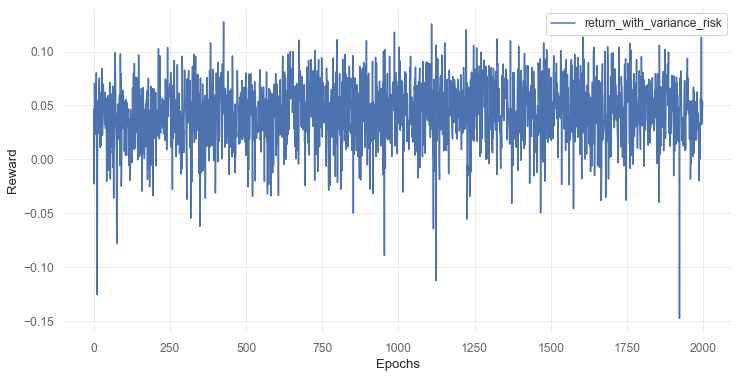

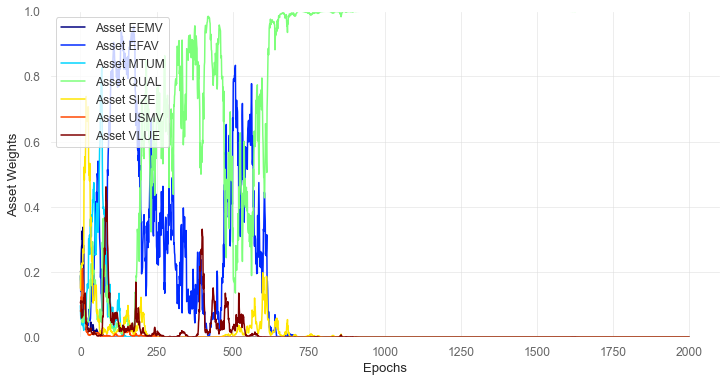

In [ ]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model_run, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

In [ ]:
(test_input_returns+1).cumprod().plot()

In [ ]:
(test_input_returns.sum(axis=1)+1).cumprod().plot()

### REINFORCE with Baseline

In [ ]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model_run, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic

In [ ]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model_run, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model_run, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')